In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
      #  print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Introduction

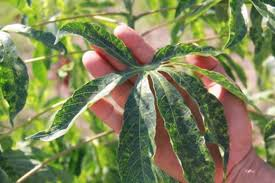

Cassava is the third-largest source of food carbohydrates in the tropics, after rice and maize. Cassava is a major staple food in the developing world, providing a basic diet for over half a billion people. It is one of the most drought-tolerant crops, capable of growing on marginal soils.

Even though they are such tough plants they often suffer from diseases, which migh result in loss for farmers and even starvation.Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this notebook we attemp to classify images of cassava plants into four most commonly occuring diseases and healhty plants as healthy , we are using a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala.


## Index

1. [Load Dataset](#LoadDataset)
2. [EDA](#EDA)
3. [Load Tf Records](#tfRec)
4. [View Images and labels](#img_labels)
5. [Loading Model and Weigths](#mod_weights)
6. [Training](#train)
7. [Predicting](#Predict)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy import stats
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.utils import to_categorical
from keras.layers import Dense
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from functools import partial 
import keras

 
## Load Dataset
  

 <div id="LoadDataset">
 </div>

In [ ]:

train_df=pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")

## EDA


<div id="EDA"></div>

The dataframe has image id and corrsponding labels

In [ ]:
train_df.head()

In [ ]:
plt.figure(figsize=[15,7])
sns.distplot(train_df['label'])
plt.xlabel('label')
plt.title('distribution of images')

We have 5 labels

0. Cassava Bacterial Blight 
1. Cassava Brown Streak Disease (CBSD)
2. Cassava Green Mottle (CGM)
3. Cassava Mosaic Disease (CMD)
4. Healthy

From distribution it can be observed that label3 ie CBSD has the highest occurence among the diseases or it could be result of a skew in the data.

In [ ]:
image_count=pd.value_counts(train_df["label"])
image_count=image_count.reset_index()

In [ ]:
image_count.rename(columns={"index":'labels','label':'count'},inplace=True)

In [ ]:
image_count.head()

In [ ]:
fig=px.pie(image_count,values='count',names='labels',title='percentage of images related to each disease')
fig.show()

## Load Tf Records

Load images and label from tf records for more information on this refer https://keras.io/examples/keras_recipes/tfrecord/



<div id="tfRec"></div>

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

In [ ]:
train_list = glob.glob('../input/cassava-leaf-disease-classification/train_images/*')

In [ ]:
train_tfrec = tf.io.gfile.glob('../input/cassava-leaf-disease-classification/train_tfrecords/*')

In [ ]:
split_ind = int(0.9 * len(train_tfrec))
TRAINING_FILENAMES, VALID_FILENAMES = train_tfrec[:split_ind], train_tfrec[split_ind:]

In [ ]:
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 8
IMAGE_SIZE = [512,512]


In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    
    if labeled != False:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image
    


In [ ]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset


In [ ]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


## Images and Labels

Lets take a look at the images and labels to get an idea of samples

<div id="img_label"></div>

In [ ]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)


image_batch, label_batch = next(iter(train_dataset))


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(7):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        if (label_batch[n] !=4):
            plt.title(label_batch[n])
        else:
            plt.title("healthy")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())


In [ ]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "cassava_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)


## Loading Model and weights

We are loading Xception network weights traind on image net without the last layer.
A final softmax layer of 5 is added since we have 5 labels.


<div id="mod_weights"></div>

In [ ]:
weigths_Xce = "../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights=weigths_Xce
    )

    base_model.trainable = False

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
 
    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics="accuracy",
    )

    return model


## Training


<div id ="train"></div>

In [ ]:
 
with strategy.scope():
    model = make_model()
    
history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

## Predicting


* <div id="predict"></div>

In [ ]:
TEST_FILENAMES = tf.io.gfile.glob("../input/cassava-leaf-disease-classification/test_tfrecords/*")
test_dataset = get_dataset(TEST_FILENAMES, labeled=False)

def show_batch_predictions(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(1):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(model.predict(img_array)[0])
        plt.axis("off")


image_batch = next(iter(test_dataset))

show_batch_predictions(image_batch)


In [ ]:
model = keras.models.load_model('../input/cassava-model/cassava_model.h5')


In [ ]:
ss = pd.read_csv(os.path.join("../input/cassava-leaf-disease-classification/sample_submission.csv"))
ss


In [ ]:
preds = []
img_array = tf.expand_dims(image_batch[0], axis=0)

preds.append(np.argmax(model.predict(img_array)[0]))
ss['label'] = preds
ss
ss.to_csv('submission.csv', index = False)

